# Hike Planning

$$
\vec h = \begin{pmatrix}
        870m \\  % uetliberg
        2~501m \\  % spitzmeilen
        4~478m \\  % matterhorn
        1~777m \\ % brüggler
        2~970m \\ % piz gloria
\end{pmatrix} 
    ~~~~~~~
\vec d = \begin{pmatrix}
        2~700m \\ % Triemlispital to Uetliberg
        6~500m \\ % Maschgenkamm
        15~000m \\ % random guess
        100m \\ % we're climbing
        10~000m \\ % random
\end{pmatrix}
$$

In [380]:
import numpy as np

heights = np.array([870, 2501, 4478])#, 1777, 2970])
distances = np.array([2700, 6500, 15000])#, 100, 10000])

In [382]:
# solution
total_time = 13.5
motivation = 1000

times = 2 * heights / motivation + distances / (5 * motivation)
print("Times in hours", times)

def cost(selection: str, revert=False) -> float:
    if revert:
        selection = selection[::-1]
    return (total_time - sum(times[i] if x == "1" else 0 for i, x in enumerate(selection))) ** 2

from itertools import product

for selection in list(product("01", repeat=3)):
    print(selection, cost(selection))

Times in hours [ 2.28   6.302 11.956]
('0', '0', '0') 182.25
('0', '0', '1') 2.3839360000000016
('0', '1', '0') 51.811204000000004
('0', '1', '1') 22.63856399999999
('1', '0', '0') 125.88839999999998
('1', '0', '1') 0.541696000000001
('1', '1', '0') 24.18672399999999
('1', '1', '1') 49.533444


In [561]:
t = np.array([2, 4, 6, 8, 4])

*Solution*

$$
\begin{aligned}
c(x) &= (T - \vec x^T \vec t)^2 \\
     &= T^2 - 2 T \vec x^T \vec t + \vec x^T (\vec t \vec t^T) \vec x
\end{aligned}
$$
This is a quadratic program with $Q = 2 \vec t \vec t^T$ and $\vec b = -2T\vec t$.

Replacing the binary variables with spins yields
$$
\begin{aligned}
c(z) &= T^2 - 2 T \sum_{j=1}^{n} \frac{1 - z_j}{2} t_j + \sum_{i, j=1}^{n} \frac{(1 - z_i)(1 - z_j)}{4} t_i t_j \\
     &= T^2 - T\sum_{j=1}^n t_j + \sum_{j=1}^n z_j T t_j + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j(1 - z_j - z_i + z_i z_j) \\
     &= T^2 - T \tau + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j 
     + \sum_{j=1}^n z_j t_j \left(T - \frac{\tau}{2}\right) + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j z_i z_j
\end{aligned}
$$
where $\tau = \sum_{j=1}^{n} t_j$. 

Replacing the spin variables by Pauli operators we have
$$
\hat H = \text{const} + \sum_{j=1}^n \hat Z_j t_j \left(T - \frac{\tau}{2}\right) + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j \hat Z_i \hat Z_j
$$
now take into account that $Z Z = I$ (which is a term that appears in the last sum) and rewrite 
$$
\hat H = \text{const} + \sum_{j=1}^n \hat Z_j t_j \left(T - \frac{\tau}{2}\right) + \frac{1}{2} \sum_{i > j}^{n} t_i t_j \hat Z_i \hat Z_j
$$
where the offset constant is
$$
T^2 - T\tau + \frac{1}{4}\sum_{i, j=1}^{n} t_i t_j + \frac{1}{4} \sum_{i=1}^{n} t_i^2
$$

In [562]:
# solution
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp

n = times.size
offset = total_time ** 2 - total_time * np.sum(times) + 0.25 * np.sum(np.outer(times, times)) + 0.25 * np.sum(times ** 2)
linear_coeffs = times * (total_time - np.sum(times) / 2)
quadratic_coeffs = 0.25 * np.outer(times, times)

hamiltonian = PauliSumOp(SparsePauliOp.from_sparse_list(
    [("", [], offset)] + 
    [("Z", [i], coeff) for i, coeff in enumerate(linear_coeffs)] +
    [("ZZ", [i, j], quadratic_coeffs[i, j]) for i in range(n) for j in range(i + 1, n)] +
    [("ZZ", [j, i], quadratic_coeffs[j, i]) for i in range(n) for j in range(i + 1, n)],
    num_qubits=n
))

### Evaluating the cost function

First, construct the QAOA ansatz and then write a function to evaluate the energy. Given a quantum circuit, you can evaluate the expectation value as

In [384]:
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.opflow import PauliSumOp

example_op = PauliSumOp.from_list([("ZZ", 1), ("ZI", -1)])
example_circuit = QuantumCircuit(2)
example_circuit.rxx(0.5, 0, 1)

expectation = Statevector(example_circuit).expectation_value(example_op.primitive)

In [393]:
# solution

from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz, RealAmplitudes

ansatz = QAOAAnsatz(hamiltonian, reps=1)

basis = ["h", "rx", "rz", "rzz"]
unrolled = transpile(ansatz, basis_gates=basis)
print("Depth:", unrolled.depth())
print("Operations:", unrolled.count_ops())

hardware_basis = ["x", "sx", "rz", "cx"]
unrolled = transpile(ansatz, basis_gates=hardware_basis)
print("Depth:", unrolled.depth())
print("Operations:", unrolled.count_ops())

really building
Depth: 6
Operations: OrderedDict([('h', 3), ('rz', 3), ('rzz', 3), ('rx', 3)])
Depth: 18
Operations: OrderedDict([('rz', 21), ('sx', 9), ('cx', 6)])


In [386]:
ansatz = RealAmplitudes(hamiltonian.num_qubits, reps=3, entanglement="pairwise")

In [394]:
# solution
def energy(values):
    bound_circuit = ansatz.bind_parameters(values)
    # the energy is a real value! also we want to optimize real parameters
    return np.real(Statevector(bound_circuit).expectation_value(hamiltonian.primitive))

### Optimize the energy

Now optimize the energy. You could for instance use one of Qiskit's built-in optimizers as

In [395]:
from qiskit.algorithms.optimizers import COBYLA

def example_function(x):
    return (np.linalg.norm(x) - 1) ** 2

example_x0 = np.array([1, 1])  # initial point

example_result = COBYLA().minimize(example_function, example_x0)

print("Minimum at:", example_result.x)
print("Function value:", example_result.fun)

Minimum at: [0.9826468  0.18479216]
Function value: 1.6530767025061928e-08


In [396]:
# solution

# reference energy
from qiskit.algorithms import NumPyMinimumEigensolver

exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(hamiltonian)
print("Exact:", exact_result.eigenvalue)

# minimize the energy
from qiskit.algorithms.optimizers import COBYLA

initial_point = np.arange(ansatz.num_parameters)
optimizer = COBYLA()
result = optimizer.minimize(energy, initial_point)
print("QAOA:", result.fun) 

print(result.x)

Exact: (0.5416960000000159+0j)
QAOA: 25.09868610663512
[2.39077764 0.46517682]


In [399]:
# solution

# sampling probability of an optimal solution
optimal_state = Statevector(ansatz.bind_parameters(result.x))
sampling_probabilities = optimal_state.probabilities_dict(decimals=2)

costs = [(state, cost(state, True), probability) for state, probability in sampling_probabilities.items()]

# get optimal states
sorted_by_cost = sorted(costs, key=lambda value: value[1])

print("Best solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_cost[i])
print()

# sort by sampling probability
sorted_by_prob = sorted(costs, key=lambda value: value[2])

print("Most likely solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_prob[~i])


Best solutions:
('101', 0.541696000000001, 0.38)
('100', 2.3839360000000016, 0.12)
('110', 22.63856399999999, 0.11)
('011', 24.18672399999999, 0.01)
('111', 49.533444, 0.32)

Most likely solutions:
('101', 0.541696000000001, 0.38)
('111', 49.533444, 0.32)
('100', 2.3839360000000016, 0.12)
('110', 22.63856399999999, 0.11)
('001', 125.88839999999998, 0.03)


### Using CVaR expectation

In [484]:
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms import QAOA
from qiskit.opflow import CVaRExpectation
from qiskit.algorithms.optimizers import *


energies = []
def store_energy(*args):
    energies.append(args[2])

    
initial_point = np.array([0.5, 1])
# initial_point = np.(2)
optimizer = SPSA(maxiter=1000, perturbation=0.01, learning_rate=0.00001, callback=store_energy)
expectation = CVaRExpectation(alpha=0.2)
# expectation = None

qaoa = QAOA(optimizer=optimizer, 
            expectation=expectation, 
            include_custom=True,
            initial_point=initial_point,
            reps=1,
#             callback=store_energy,
            quantum_instance=AerSimulator())
result = qaoa.compute_minimum_eigenvalue(hamiltonian)
print("QAOA:", result.eigenvalue)

building
really building
QAOA: (0.5416960000000159+0j)


In [485]:
result.optimal_point

array([0.50558657, 0.98698426])

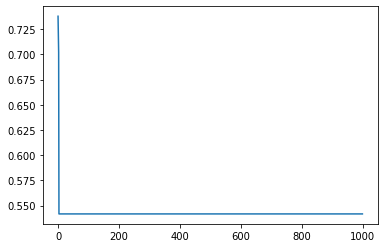

In [486]:
import matplotlib.pyplot as plt

plt.plot(energies)

### Transpilation

Now we'll transpile the circuit for the ``ibmq_quito`` device.

In [539]:
from qiskit.test.mock import FakeQuito
backend = FakeQuito()

# or for the actual device, if you have an IBM Quantum Experience account
# from qiskit import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(group="open")
# backend = provider.get_backend("ibmq_quito")

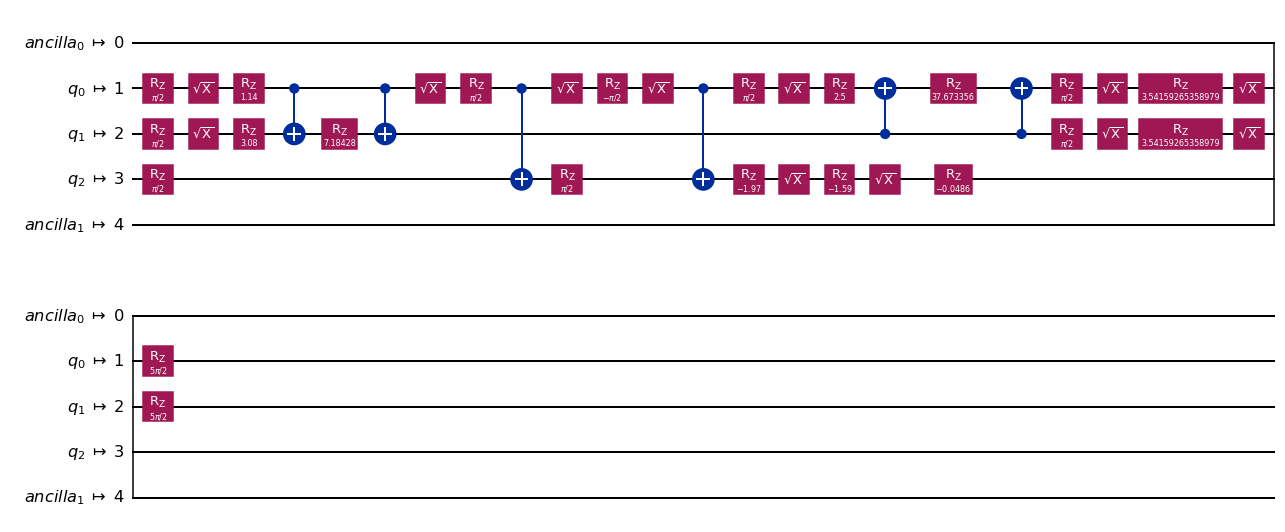

In [549]:
from qiskit import transpile

values = [0.2, 0.5]
bound = ansatz.bind_parameters(values)
transpiled = transpile(bound, backend, optimization_level=3)
transpiled.draw("mpl", style="iqx")

In [550]:
num_cx = 9
cx_fidelity = 1 - 1.047e-2

expected_fidelity = cx_fidelity ** num_cx
print(expected_fidelity)

0.9096214413777552


### Pulse efficient decomposition

*Note: This works correctly only for a circuit with bound parameters.*

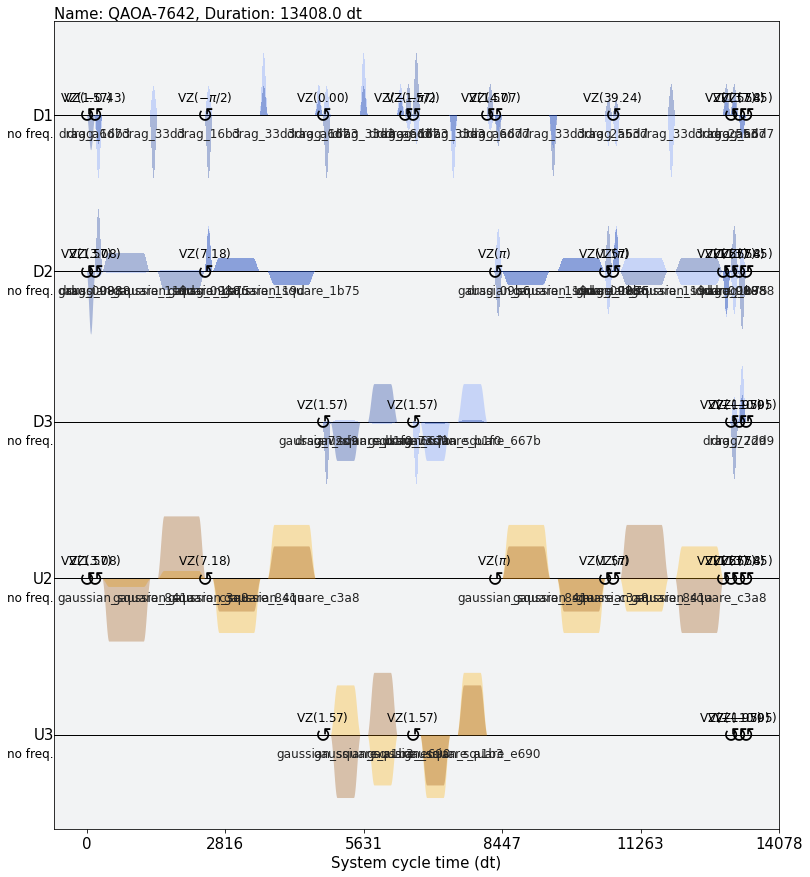

In [551]:
from qiskit import schedule

schedule(transpiled, backend).draw()

In [552]:
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks, ConsolidateBlocks, EchoRZXWeylDecomposition, RZXCalibrationBuilderNoEcho,
    UnrollCustomDefinitions, BasisTranslator, Optimize1qGatesDecomposition
)

# Build the pass manager for the parameterized circuit
rzx_basis = ['rzx', 'rz', 'x', 'sx']

# Build a pass manager for the CX decomposition (works only on bound circuits)
pm = PassManager([
  # Consolidate consecutive two-qubit operations.
  Collect2qBlocks(),
  ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),

  # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
  EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),

  # Attach scaled CR pulse schedules to the RZX gates.
  RZXCalibrationBuilderNoEcho(backend),

  # Simplify single-qubit gates.
  UnrollCustomDefinitions(std_eqlib, rzx_basis),
  BasisTranslator(std_eqlib, rzx_basis),
  Optimize1qGatesDecomposition(rzx_basis),
])

In [553]:
rzx_efficient = pm.run(transpiled)

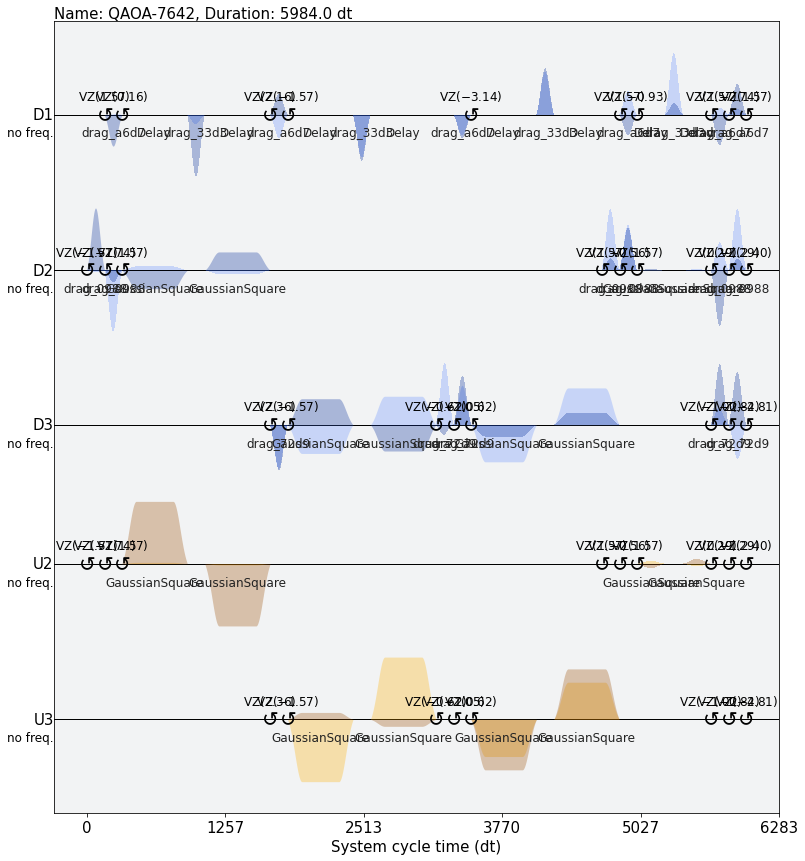

In [554]:
schedule(rzx_efficient, backend).draw()

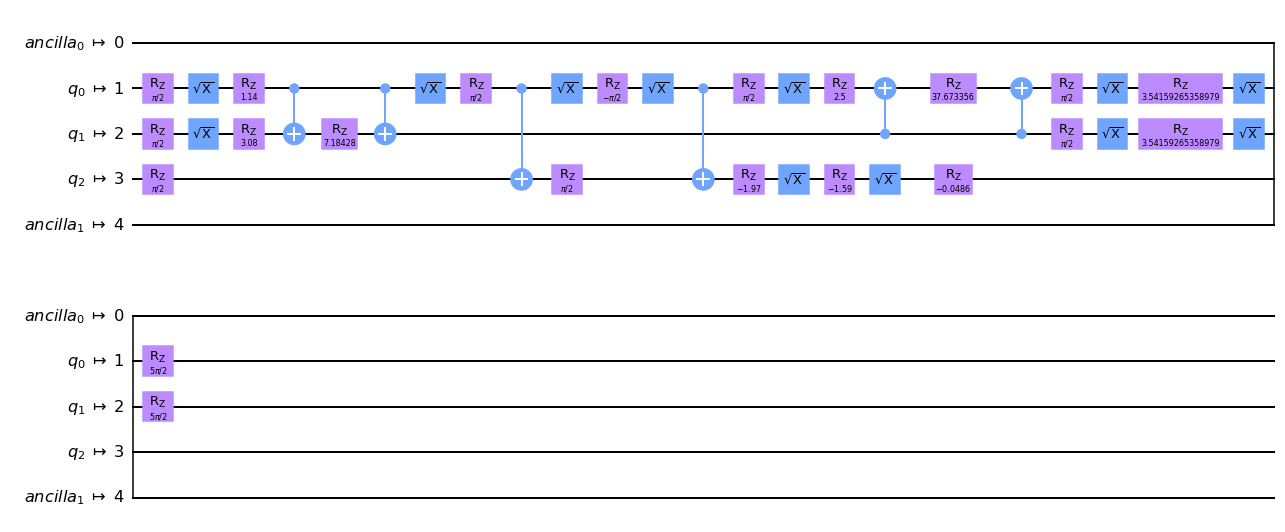

In [555]:
transpiled.draw("mpl")

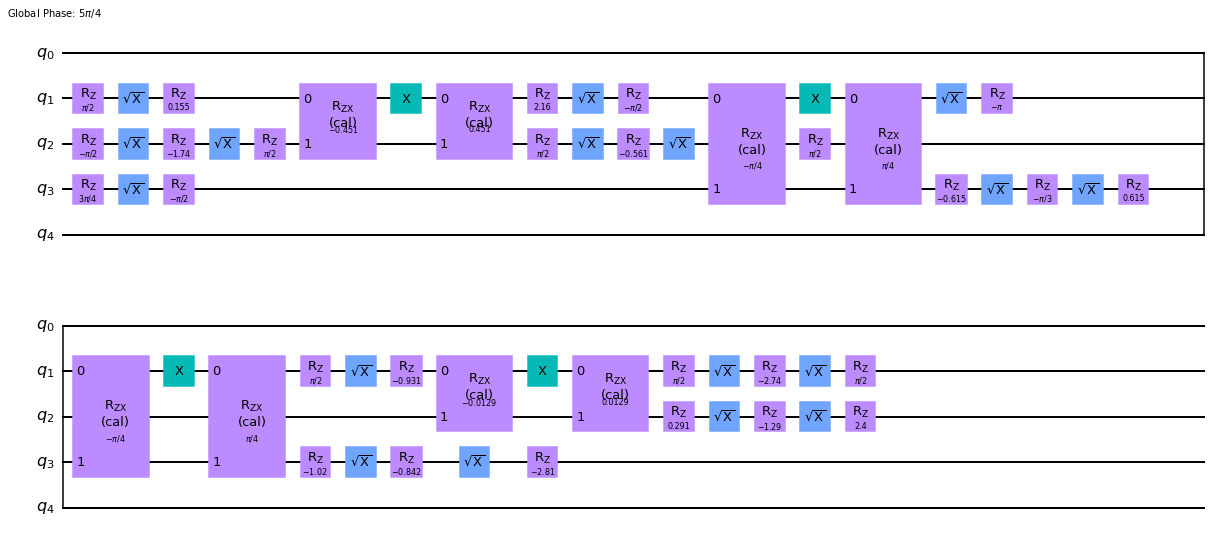

In [556]:
rzx_efficient.draw("mpl")

In [559]:
print("Reduction by a factor of:", end=" ")
print(schedule(transpiled, backend).duration / schedule(rzx_efficient, backend).duration)

Reduction by a factor of: 2.2406417112299466
